# Setting up environment.

In [ ]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)
print(f"PyTorch version: {TORCH}")

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)
print(f"CUDA Version: {CUDA}")

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

PyTorch version: 1.12.1
CUDA Version: cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 35.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 27.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 13.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 32.4 MB/s 
Looking in indexes: http

In [ ]:
# You can now install PyG via Anaconda for all major OS/PyTorch/CUDA combinations 🤗 
# Given that you have PyTorch >= 1.8.0 installed, simply run
# conda install pyg -c pyg

In [ ]:
!nvidia-smi

Tue Oct  4 19:43:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    color = color.cpu()
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

# Graph Datasets
> https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

A graph is used to model pairwise relations (edges) between objects (nodes). A simple example of an unweighted and undirected graph with three nodes and four edges. Each node contains exactly one feature:

graph.svg

In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

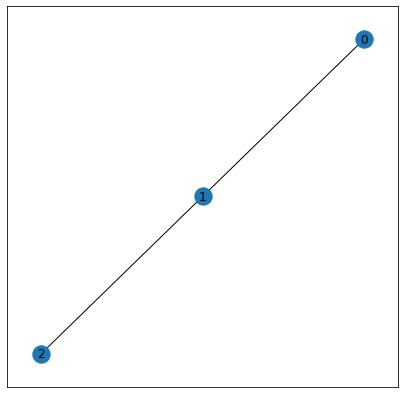

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## Graph Data Handling

A single graph in PyG is described by an instance of torch_geometric.data.Data, which holds the following attributes by default:

    data.x: Node feature matrix with shape [num_nodes, num_node_features]

    data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

    data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]

    data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

    data.pos: Node position matrix with shape [num_nodes, num_dimensions]


In [ ]:
for key, item in data:
  print(f"{key} found in data.")

x found in data.
edge_index found in data.


In [ ]:
data.x

tensor([[-1.],
        [ 0.],
        [ 1.]])

In [ ]:
data.num_nodes

3

In [ ]:
data.num_node_features

1

Note that edge_index, i.e. the tensor defining the source and target nodes of all edges, is not a list of index tuples.

```
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
```
If you want to write your indices this way, you should transpose and call contiguous on it before passing them to the data constructor: ```edge_index.t().contiguous()```

In [ ]:
data.edge_index

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])

In [ ]:
data.num_edges

4

In [ ]:
data.has_isolated_nodes()

False

In [ ]:
data.has_self_loops()

False

In [ ]:
data.is_directed()

False

## Dataset

PyG contains a large number of common benchmark datasets, e.g., all Planetoid datasets (Cora, Citeseer, Pubmed), all graph classification datasets from http://graphkernels.cs.tu-dortmund.de and their cleaned versions, the QM7 and QM9 dataset, and a handful of 3D mesh/point cloud datasets like FAUST, ModelNet10/40 and ShapeNet.

Initializing a dataset is straightforward. An initialization of a dataset will automatically download its raw files and process them to the previously described Data format. E.g., to load the KarteClub dataset:

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

In [ ]:
len(dataset)

1

In [ ]:
dataset.num_classes

4

In [ ]:
dataset.num_node_features

34

Here, the dataset contains only a single, undirected citation graph:

In [ ]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

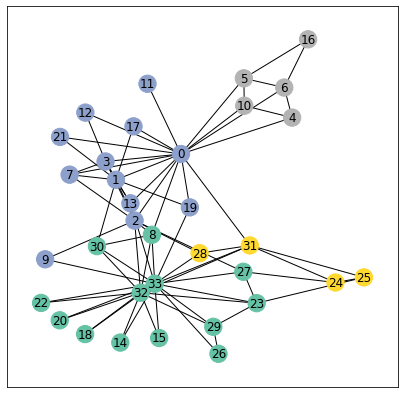

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

# Models

# Introduction: Graph Neural Networks

Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community.
Here, **Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

This is done by following a simple **neural message passing scheme**, where node features $\mathbf{x}_v^{(\ell)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks.

Following [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), we create a GCN model based on PyTorch Geometric.

PyTorch Geometric provides an easy access to this dataset via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage:

### Graph Convolutional Networks

The constructor defines three GCNConv layers which get called in the forward pass of our network. Note that the non-linearity is not integrated in the conv calls and hence needs to be applied afterwards. Here, we chose to use tanh as our intermediate non-linearity and finally output a distribution over the number of classes though a linear classfier.

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h
    
    def reset_parameters(self):
      self.conv1.reset_parameters()
      self.conv2.reset_parameters()
      self.conv3.reset_parameters()
      self.classifier.reset_parameters()

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


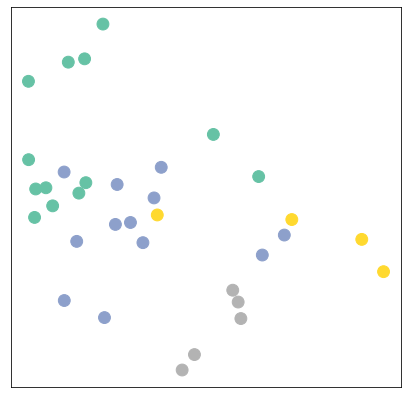

In [ ]:
model = GCN().to(device)
data = data.to(device)

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

## Training GNNs for Network Embedding

Let’s train this model on the training nodes for 400 epochs:

<IPython.core.display.Javascript object>

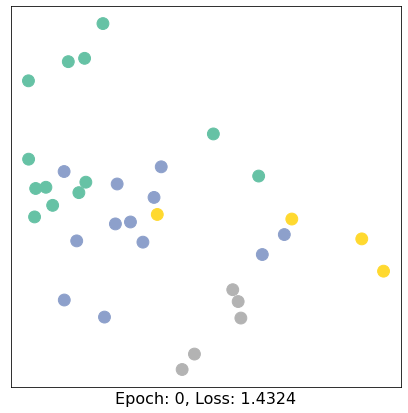

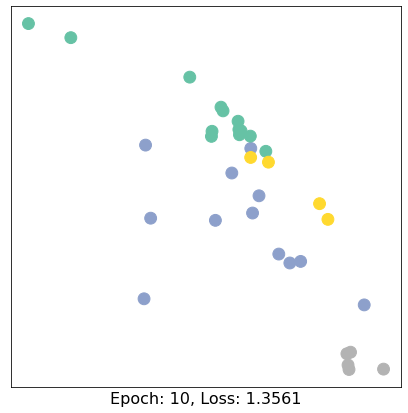

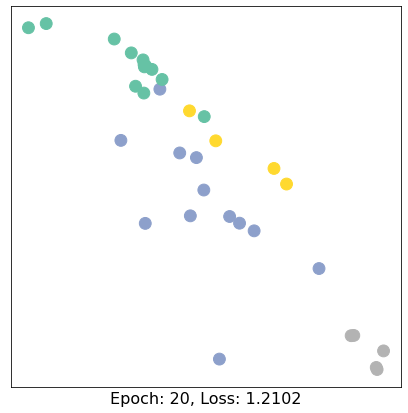

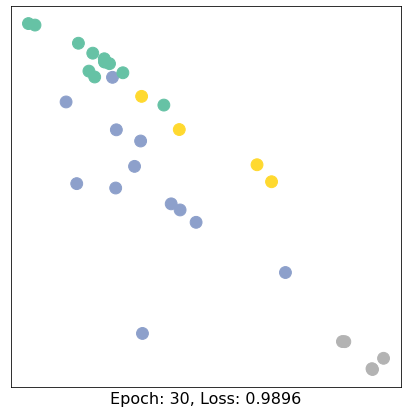

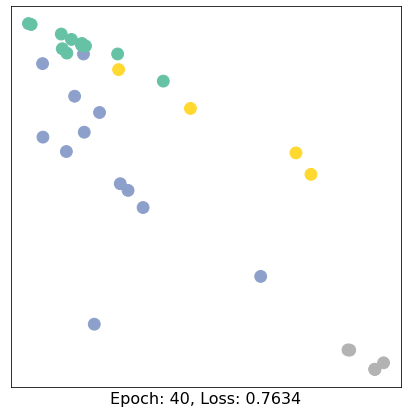

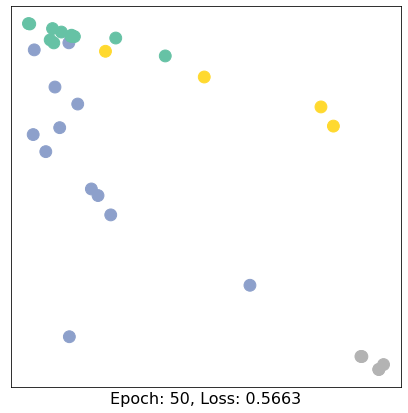

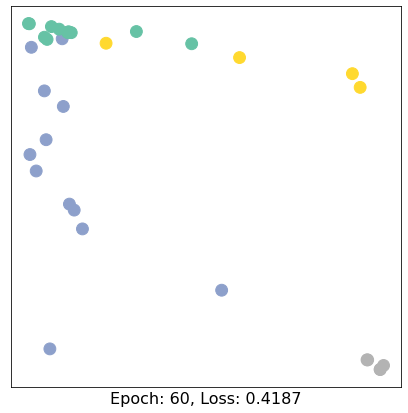

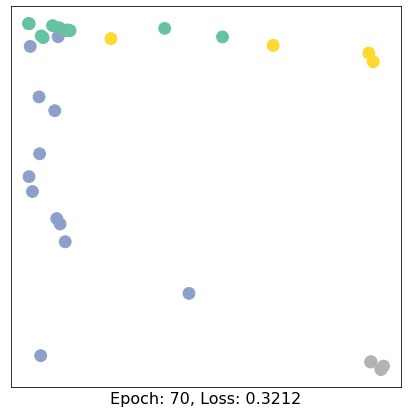

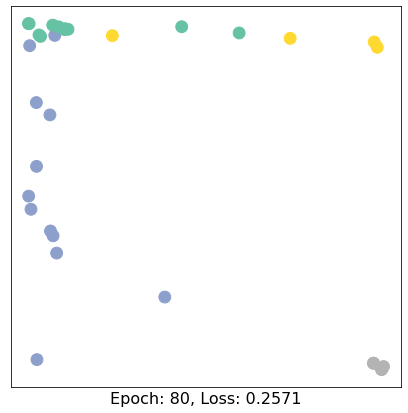

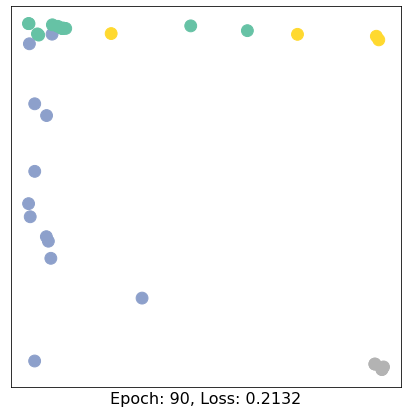

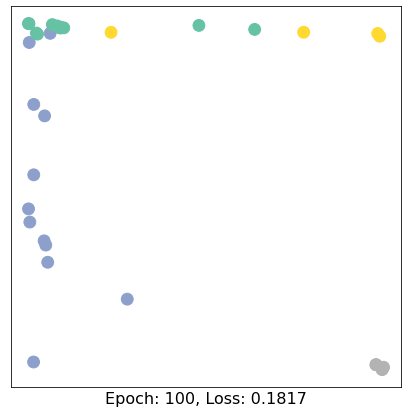

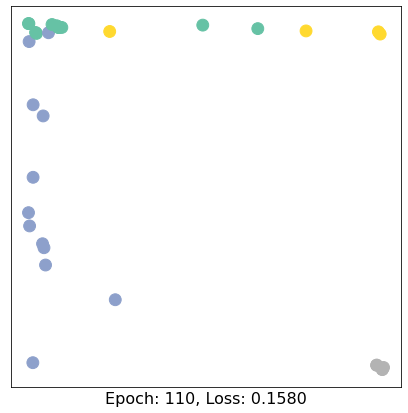

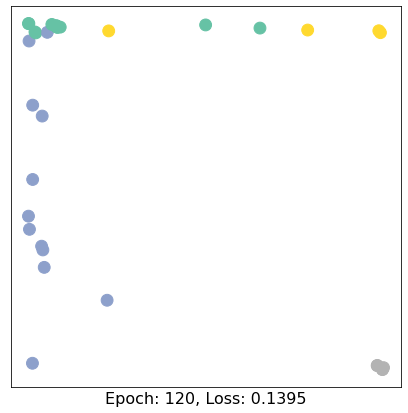

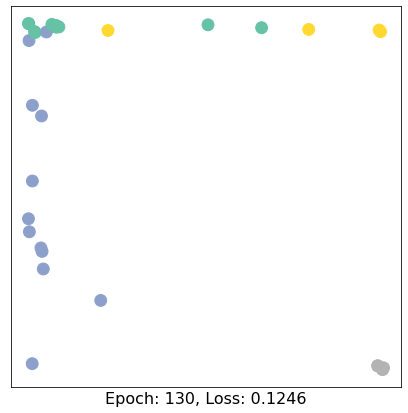

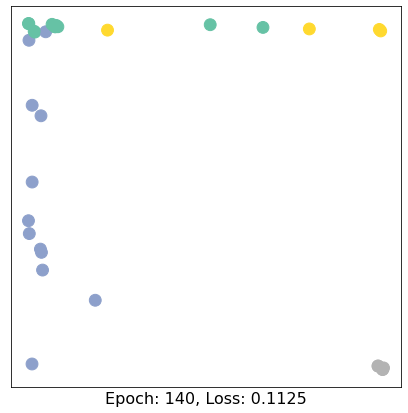

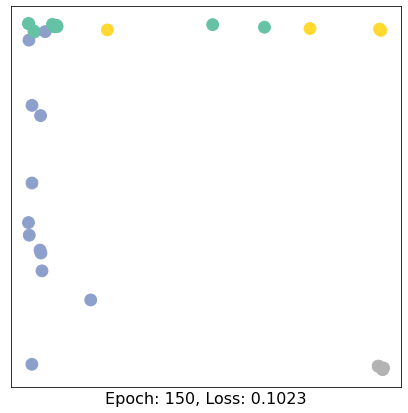

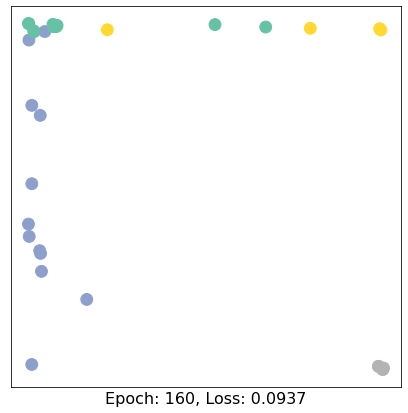

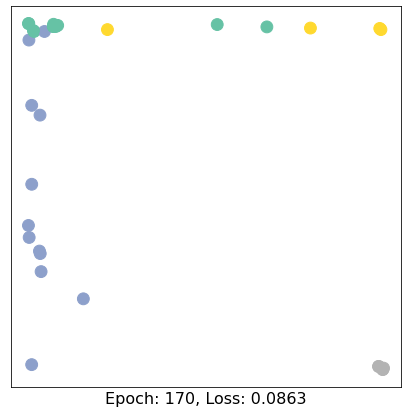

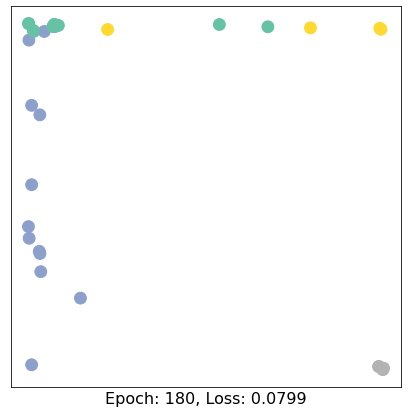

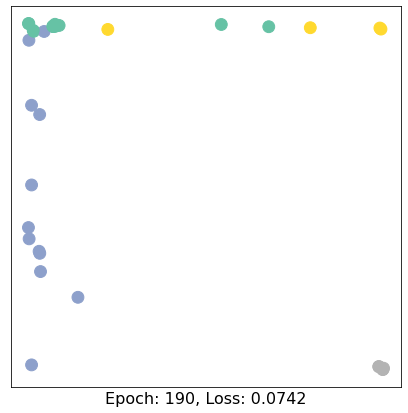

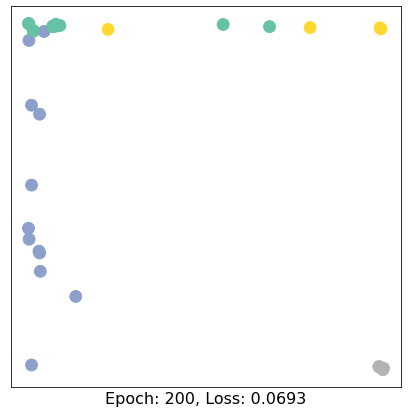

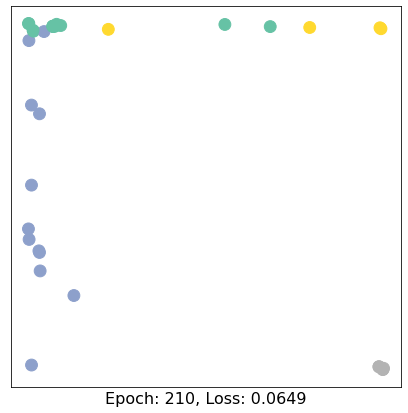

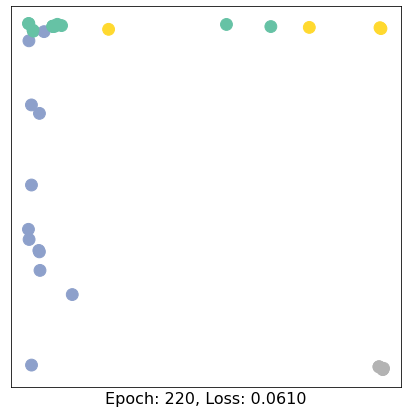

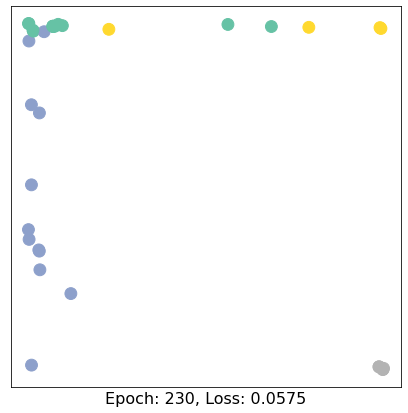

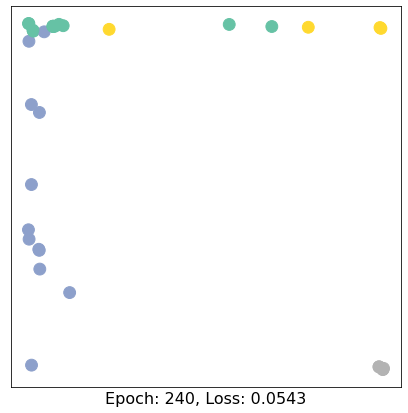

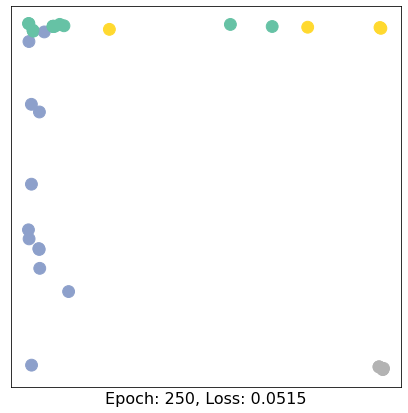

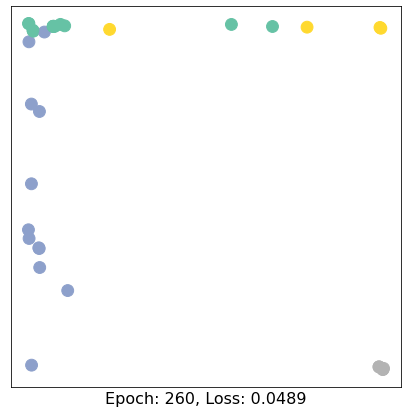

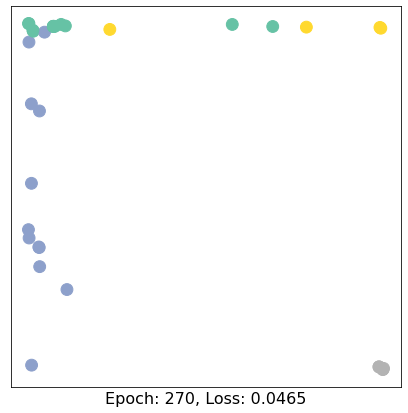

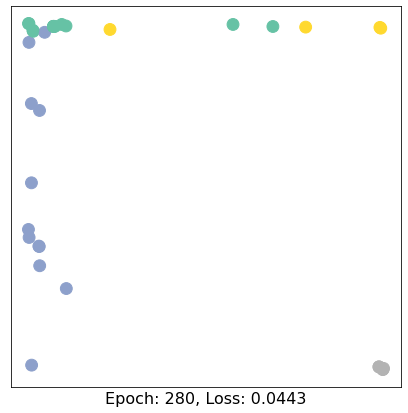

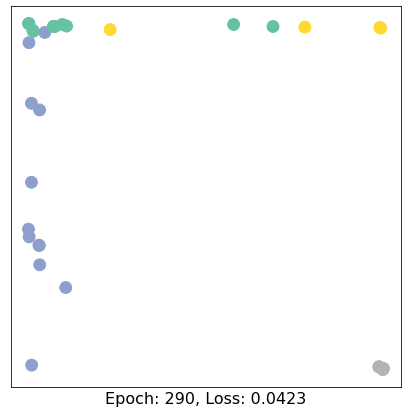

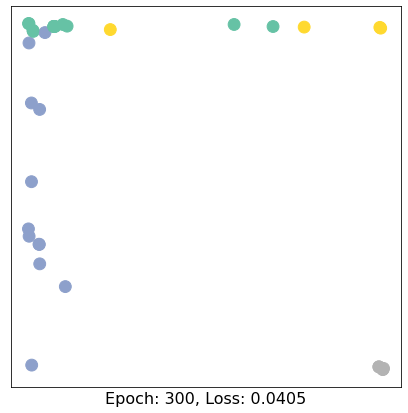

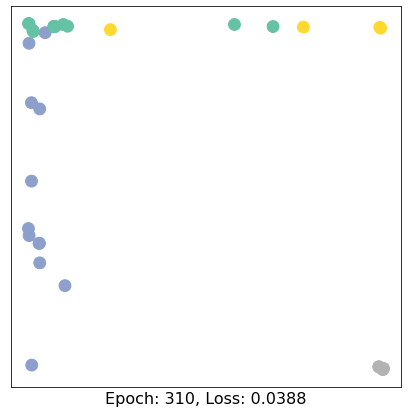

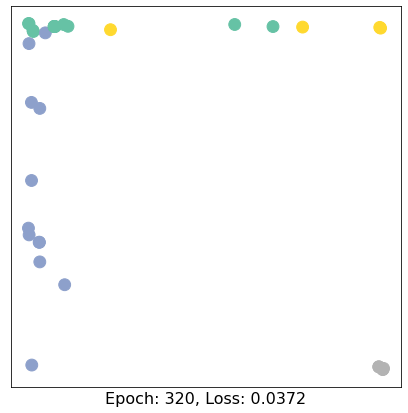

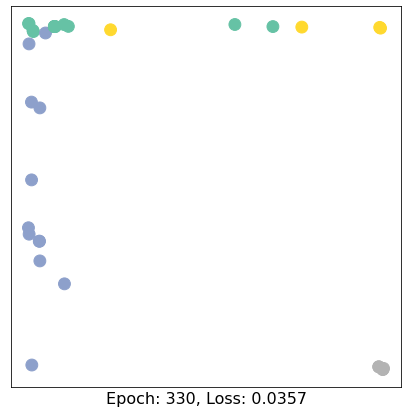

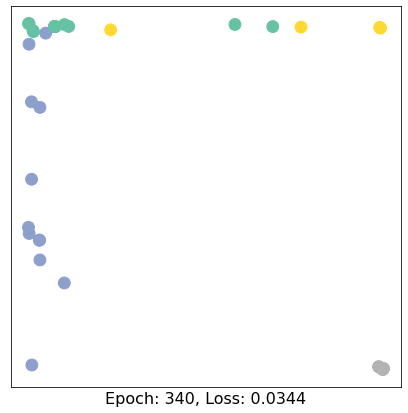

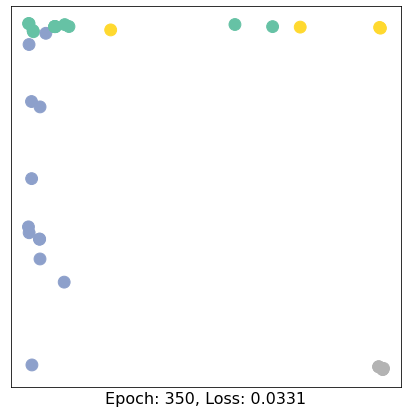

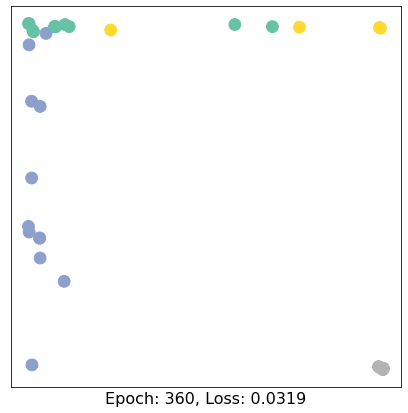

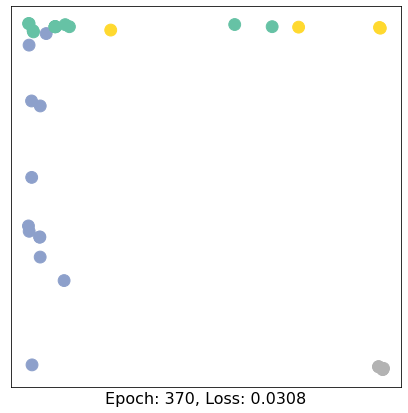

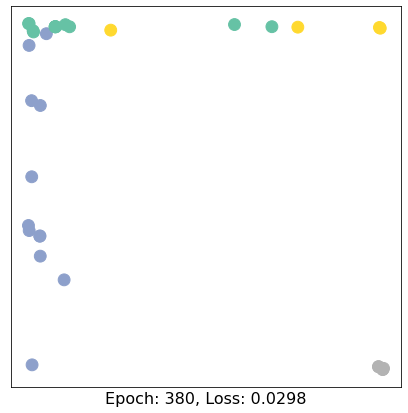

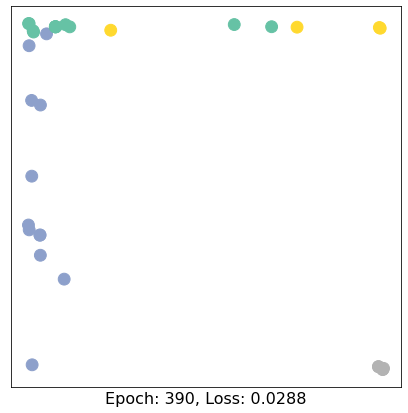

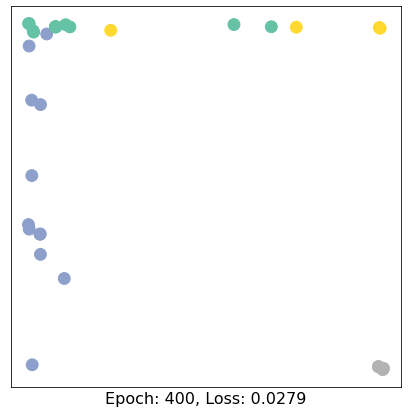

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN().to(device)
data = data.to(device)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train(data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.1)

# Task: Node Classification

We will use a simple GCN layer and replicate the experiments on the Cora citation dataset. Let’s download Cora first, the standard benchmark dataset for semi-supervised graph node classification:

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [ ]:
dataset

Cora()

## Data Split & Mask

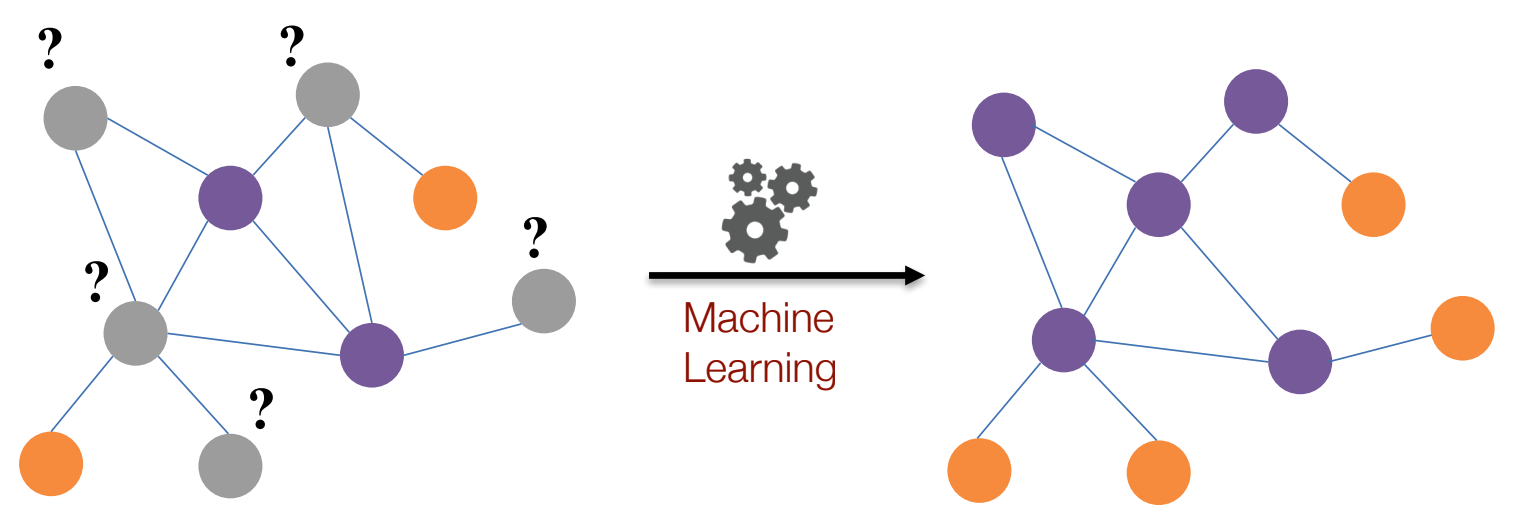

> from the slides of CS224W.

In node classification task, the graph structure is shared over layers.

[semi-supervised learning] We **only make use of the training nodes for computing the loss during training**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Here, the Cora dataset contains only a single, undirected citation graph:

In [ ]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
data.is_undirected()

True

In [ ]:
data.train_mask.sum().item()

140

In [ ]:
data.val_mask.sum().item()

500

In [ ]:
data.test_mask.sum().item()

1000

This time, the **Data** objects holds a label for each node, and additional node-level attributes: **train_mask**, **val_mask** and **test_mask**, where

- **train_mask** denotes against which nodes to train (140 nodes),

- **val_mask** denotes which nodes to use for validation, e.g., to perform early stopping (500 nodes),

- **test_mask** denotes against which nodes to test (1000 nodes).

In [ ]:
for key in data:
  print(key)

('x', tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('edge_index', tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]]))
('y', tensor([3, 4, 4,  ..., 3, 3, 3]))
('train_mask', tensor([ True,  True,  True,  ..., False, False, False]))
('val_mask', tensor([False, False, False,  ..., False, False, False]))
('test_mask', tensor([False, False, False,  ...,  True,  True,  True]))


## Build a Model

Let’s implement a two-layer GCN:

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


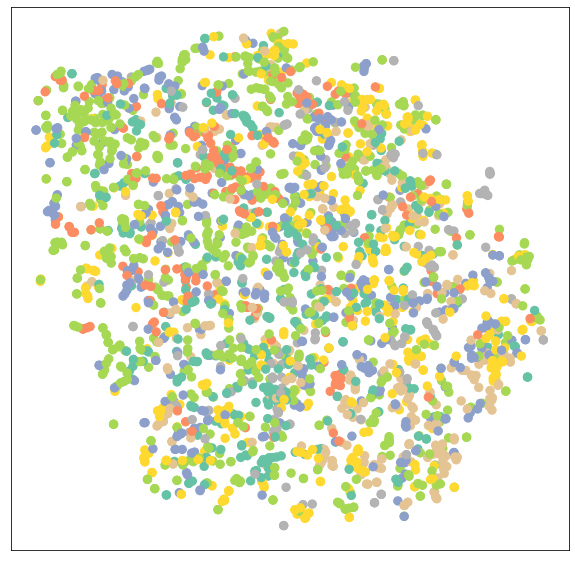

In [ ]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Full Training Pipeline

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

epochs = 1000
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss() 
# This criterion computes the cross entropy loss between input and target. 
# It is useful when training a classification problem with C classes
# The input is expected to contain raw, unnormalized scores for each class. 
# input has to be a Tensor of size (C) for unbatched input, (minibatch,C) 
# or (minibatch,C,d1,d2,...,dK) with K≥1K \geq 1K≥1 for the K-dimensional case.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss, h

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

train_loss = []
test_acc = []
for epoch in range(1, epochs + 1):
    loss, _ = train()
    train_loss.append(loss.item())
    acc = test()
    test_acc.append(acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.1758
Epoch: 002, Loss: 0.1822
Epoch: 003, Loss: 0.1781
Epoch: 004, Loss: 0.1695
Epoch: 005, Loss: 0.1943
Epoch: 006, Loss: 0.1976
Epoch: 007, Loss: 0.1987
Epoch: 008, Loss: 0.1738
Epoch: 009, Loss: 0.1500
Epoch: 010, Loss: 0.1802
Epoch: 011, Loss: 0.1662
Epoch: 012, Loss: 0.1841
Epoch: 013, Loss: 0.1678
Epoch: 014, Loss: 0.1655
Epoch: 015, Loss: 0.1523
Epoch: 016, Loss: 0.1851
Epoch: 017, Loss: 0.1862
Epoch: 018, Loss: 0.1870
Epoch: 019, Loss: 0.1694
Epoch: 020, Loss: 0.1807
Epoch: 021, Loss: 0.1722
Epoch: 022, Loss: 0.1662
Epoch: 023, Loss: 0.1646
Epoch: 024, Loss: 0.1556
Epoch: 025, Loss: 0.1615
Epoch: 026, Loss: 0.1473
Epoch: 027, Loss: 0.1900
Epoch: 028, Loss: 0.1695
Epoch: 029, Loss: 0.1690
Epoch: 030, Loss: 0.1923
Epoch: 031, Loss: 0.2007
Epoch: 032, Loss: 0.1613
Epoch: 033, Loss: 0.1723
Epoch: 034, Loss: 0.1954
Epoch: 035, Loss: 0.1856
Epoch: 036, Loss: 0.1383
Epoch: 037, Loss: 0.1564
Epoch: 038, Loss: 0.1612
Epoch: 039, Loss: 0.1931
Epoch: 040, Loss: 0.1606


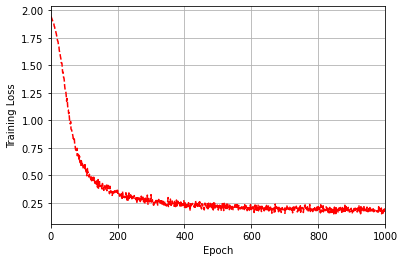

In [ ]:
import numpy as np

t = np.arange(epochs)
plt.xlabel('Epoch')
plt.xlim([0, 1000])
plt.ylabel('Training Loss')
plt.plot(t, train_loss, 'r--')
plt.grid(True)
plt.show()

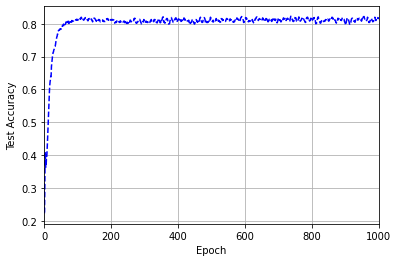

In [ ]:
import numpy as np

t = np.arange(epochs)
plt.xlabel('Epoch')
plt.xlim([0, 1000])
plt.ylabel('Test Accuracy')
plt.plot(t, test_acc, 'b--')
plt.grid(True)
plt.show()

## Hyperparameters

The following parameters are important for the final model performance: *learning rate, number of layers, hidden dimensions, early stopping*, etc. Meanwhile, different types of graph convolution operators also play an important role for specific tasks, such as node classification, link prediction, and graph-level tasks.

**GCNConv** The graph convolutional operator from the "Semi-supervised Classification with Graph Convolutional Networks" paper

**ChebConv** The chebyshev spectral graph convolutional operator from the "Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering" paper

**SAGEConv** The GraphSAGE operator from the "Inductive Representation Learning on Large Graphs" paper

**GINConv** The graph isomorphism operator from the "How Powerful are Graph Neural Networks?" paper





## Result Report and Demonstartion

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


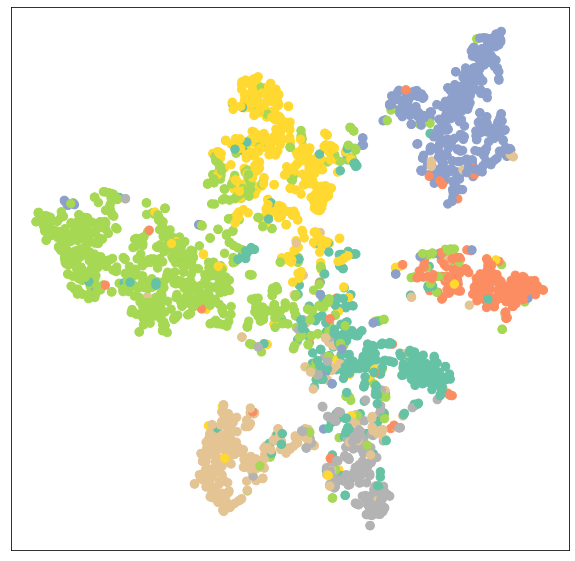

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y.cpu())